In [11]:
!pip install wget tensorflow==2 pandas (numpy as np) keras

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `pip install wget tensorflow==2 pandas (numpy as np) keras'


In [6]:
import wget
url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
wget.download(url)

url = 'https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

In [7]:
import numpy as np
import json

In [8]:
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])

In [9]:
data = np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

###Split Data

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.2)


###Preprocessing

In [7]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [13]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))

In [14]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.004451992, 0.4081574)

In [16]:
max_num_words = 40000
embedding_dim=len(embeddings_index['the'])
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)

train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')
word_index = tokenizer.word_index

In [17]:
num_words = min(max_num_words, len(word_index) )+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

OneHotEncoder(sparse=False)

In [19]:
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)

In [20]:
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

###Model Prep

In [21]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

In [22]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           676700    
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 512)           731136    
_________________________________________________________________
dropout (Dropout)            (None, 16, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [24]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Train on 18960 samples, validate on 4740 samples
Epoch 1/20
18960/18960 [==============================] - 260s 14ms/sample - loss: 4.6572 - acc: 0.0453 - val_loss: 3.8631 - val_acc: 0.1019
Epoch 2/20
18960/18960 [==============================] - 212s 11ms/sample - loss: 3.4128 - acc: 0.1429 - val_loss: 2.3672 - val_acc: 0.3732
Epoch 3/20
18960/18960 [==============================] - 211s 11ms/sample - loss: 2.3158 - acc: 0.3472 - val_loss: 1.5130 - val_acc: 0.5751
Epoch 4/20
18960/18960 [==============================] - 212s 11ms/sample - loss: 1.6698 - acc: 0.5134 - val_loss: 1.1349 - val_acc: 0.6835
Epoch 5/20
18960/18960 [==============================] - 212s 11ms/sample - loss: 1.2887 - acc: 0.6179 - val_loss: 0.8948 - val_acc: 0.7481
Epoch 6/20
18960/18960 [==============================] - 213s 11ms/sample - loss: 1.0305 - acc: 0.6955 - val_loss: 0.7888 - val_acc: 0.7806
Epoch 7/20
18960/18960 [==============================] - 213s 11ms/sample - loss: 0.8728 - acc: 0.7469 -

###Metric Visualization

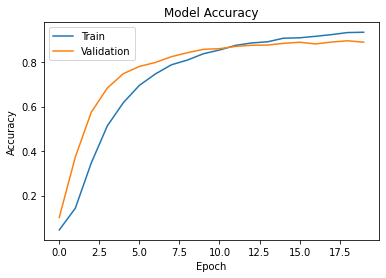

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

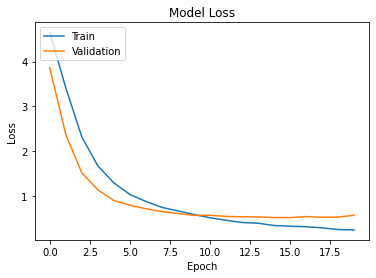

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###Saving Model

In [29]:
import pickle
import json

In [34]:
model.save('intents.h5')

with open('classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

###Realtime execution

In [4]:
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [45]:
pip uninstall h5py


Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0


In [46]:
pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 4.2 MB/s 


In [1]:
import pickle

from tensorflow.python.keras.models import load_model

model = load_model('intents.h5')

with open('classes.pkl','rb') as file:
  classes = pickle.load(file)

with open('tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

In [ ]:
t

In [5]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)

In [13]:
import numpy as np

In [15]:
nlu.get_intent("The refund has been credited to your account")

'balance'

####Tweets

In [16]:
tweets = ['@LiveFromALounge @IndiGo6E Actually prefer the cucumber tomato over the junglee! Goes better with chips',
 "@IndiGo6E PNR sent. you can check at your end (don't change anything pls, just let me know if available or not)",
 '@SK10940154 @LiveFromALounge @IndiGo6E I felt the need to have it on GAU BOM 3.5 hr long morning flight',
 '@IndiGo6E my flight was cancelled by indigo so I select for refund process. I talked with customer care person and she told me I will get full refund but I got only 10% refund mail.',
 '@LiveFromALounge @IndiGo6E Oops, forgot to see the price. Free is always welcome.',
 '@SK10940154 @IndiGo6E You don’t have to eat it on board, you can bring it home with you.',
 '@LiveFromALounge @IndiGo6E A better question would be who is brave enough to take off their mask in a tight space where people have been packed like sheep?',
 'Is there a glitch in the matrix? On an upcoming @IndiGo6E flight there is no Chicken Junglee Sandwich but a new Chicken Cucumber Tomato Sandwich. https://t.co/5zLQJSj18X',
 '@IndiGo6E  hey indigo airline you need to look at your customer service rep, when they put on hold to check the information they disconnect the call when they don’t have any information.\nThis happened thrice with me just now.',
 '@IndiGo6E We were on the same flight of thought! Another similarity we share is our mutual love for unparalleled #service. Do welcome us onboard!',
 '@arvindpandey732 @DGCAIndia @JM_Scindia @flyingbeast320 @airindiain @Dchautala @IndiGo6E @airvistara @airasia @flyspicejet Excellent sir',
 '@IndiGo6E Look at your website loading for past 20 mins https://t.co/ZxmNfRdCDw',
 '@IndiGo6E my flight was cancelled by indigo so I select for refund process i talk with customer care person he told me I will get full refund but I got only 10% refund mail.',
 '@IndiGo6E Even me too',
 '@IndiGo6E @IndiGo6E damaged my checking baggage https://t.co/WfQ0pwHJpy',
 '@IndiGo6E Itz been a month since i have raised my query, still the efforts have remained halfhearted. Is this how you treat your customers. Is this much of time u need to verify a ticket waiver.#INDIGO #MoCA',
 '@IndiGo6E : Hi, can I get a copy of receipt for excess baggage which I had paid.',
 '@IndiGo6E @IndiGo6E damaged my checking baggage and now running away from the situation https://t.co/gT8PwSkEKs',
 "@IndiGo6E Couldn't cancel on your website. Lost my entire money. Anyways, thanks for the response.",
 '@sritianne @IndiGo6E Aap vapas kab aayenge kumkum bhagya me',
 '@IndiGo6E I see there is a flight on 4th Feb from Bangalore to Allahabad.. Can you help me reschedule my flight to 4th Feb please?',
 '@IndiGo6E Offer is not Applied on SXR To IXJ',
 '@IndiGo6E Sure. Please do inform your team to be more careful in future. Also a proper reasonable response like this instead of complete ignorance ( as happened at airport) will be better. Again thanks for your other great services @IndiGo6E 👍',
 '@IndiGo6E @QueenbEEE06 IndiGo is cheater..',
 '@IndiGo6E No..Many more',
 "@IndiGo6E This is what I am getting when trying to rebook.. Tell me what do I do.. If I go for any other company flight they will charge me at least 2 times now. I am fucked, isn't it? https://t.co/Jj74zpIlP5",
 '@IndiGo6E Have messaged you, please check',
 '@IndiGo6E Pretty cheap marketing strategy.',
 '@IndiGo6E Dear fellow Passengers, never DM these guys…no use….',
 '@QueenbEEE06 @IndiGo6E Twitter handle kisi kaam ke nahi hote, bus naam ke hote hain',
 '@IndiGo6E Great! Appreciate!',
 'I had flight on 14th jan. I have tested covid positive on 13th jan. Due to this i had cancelled my flight.\nThere is no refund from @IndiGo6E  and no help from @goibibo .Below i have attached my RTPCR report. https://t.co/J9efYI6f7Z',
 '@IndiGo6E Please check DM and respond ASAP!',
 '@IndiGo6E Shreya, I’d attached a pic of coach. As u saw, it’s full. No 50% limit is ensured. I have cut down my travel with Indigo, also because of poor de-boarding procedure. Please start to announce rows that must disembark, not just say “get up only after pax in seat before u gets up”🙏',
 '😍😍 @ysjagan @IndiGo6E \n#kadapasmartcity https://t.co/eSQYsDmYnE',
 '@IndiGo6E Hi Team, I have received my Kaching Credit Card but y 6E rewards profile is still not visible in my Indigo account. Please check',
 '@saxenasagar91 @IndiGo6E @flyspicejet @airvistara @airindiain Why arent OTA thinking of bringing a feature to import check-in process(just an in-app integration) and the boarding pass generation on their platform',
 '@aaigoaairport @AAI_Official @MoCA_GoI @PIB_Panaji @MoHFW_INDIA @IndiGo6E @flyspicejet @AirAsiaIndia @GoFirstairways @airindiain @airvistara @aairedwr Is there a link to download the pdf document',
 '@IndiGo6E Refund status link never works. Pls check before sending it.',
 "@IndiGo6E I have paid the flight fare but haven't got any confirmation of my booking kindly look on to this matter , its urgent https://t.co/Jf6xykWxVt",
 '@IndiGo6E sir feb 2 flight available sharjah to amitshar',
 'Hello @goibibo Booking ID GOFLIMT9FA521638191528. Flight cancelled by @IndiGo6E , refund request submitted but still waiting of refund. \nKindly refund asap in original source of payment.',
 'Still waiting for a call from your side @IndiGo6E , sent you all the details 3 hours ago. How long do we need to wait? https://t.co/L6OWN4goEm',
 "@IndiGo6E @MoCA_GoI   Refer my case reference number :4291640, no refund has been made till now, even when cancelation was done 1month back. For what reason, you're delaying refund to get credit ??",
 '@IndiGo6E can I carry 500ml sanitizer in checked luggage?',
 '@IndiGo6E PNR Number P977564071.\n2 adult 1 child.\nAdults have 2 dose complete.\nIs covid test mandatory before boarding??',
 '@IndiGo6E someone has just booked ticket on your airline using my Mobile number ?',
 '@IndiGo6E unable to choose any payment option without convenience fees using app. What option is there?',
 'As promised by your team at earliest @IndiGo6E https://t.co/OBy3oPYPb2',
 '@IndiGo6E  still did not received any voucher  as promised by indigo for my a pune ti chennai flight due to shud down of andsman for tourist \nPlease look over it #indigo is a reputed brand i suffered huge cancellation charges it would be big help if you provide  travel voucher https://t.co/Avu8HPRJhA',
 '@IndiGo6E My drawing of tail of IndiGo (low cost airline in India) in 15 minutes. https://t.co/7Zzf5HFy25',
 '@Cleartrip @Cleartrip @IndiGo6E if you were bothered reading my tweet. it clearly states i asked to speak to the supervisor. why is it so hard to understand! you cannot understand when i speak, nor when i type! I want to speak to a SUPERVISOR !!!!',
 'Hey @IndiGo6E, my flight got cancelled, And I am not able to reschedule or refund because your app and customer care sucks just like your operational team due to which my flight  got cancelled. At personal level lot of things on toss when you cancel flights like this.',
 '@Cleartrip @IndiGo6E please have a supervisor call me back asap. I need to close this rebooking before i lose the dates . trip id: 211227241294 https://t.co/OBum8PC7TG',
 '@saxenasagar91 @IndiGo6E @flyspicejet @airvistara @airindiain .@airvistara is the worst when it comes to boarding passes. Their IOS version doesn’t have the year of travel and hence is not acceptable by @CISFHQrs while entering the airport',
 '@IndiGo6E  i booked sharjah to amitshar is flight was cancelled i need refund my cash i checked plan b is not working for me',
 "@IndiGo6E Please do. Thank you. And they are now traveller's to tezpur. Please send luggage to tezpur at my given address, mentioned  in guwahati airport.",
 '#indigoairline @IndiGo6E @indigo : This is what good behaviour &amp; greeting happily to customers does. I specially asked for his name &amp; took picture to show how impressed I am with indigo because of him. More Power to You https://t.co/DS4g0VWlqT',
 '@IndiGo6E Flight is cancelled by Airline itself 15 Hours Prior the departure and also the link provided in the SMS (for the alteration of flight or refund) is also not working till today. Please keep update the status of refund.',
 '@IndiGo6E Shared',
 '@IndiGo6E I have a flight to the board tomorrow can I carry a water bottle, chips, and biscuits in my handbag. And also where can I carry my Pendrive in the luggage or handbag?',
 "@IndiGo6E My elderly parents got stuck in Guwhati airport due to your hyd staff's mistake of booking luggage in the name of NO SHOW passenger, whose boarding pass was not given. Why should passengers bear the brunt of the negligence of your staff? #6E 384, WQKJNN. @AAI_Official",
 '@IndiGo6E I am awaiting a response on my tweets... https://t.co/hPeqVWF8Ut',
 'When will the airlines move 100% to a mobile friendly boarding pass🤔, \nthe existing ones have a really bad UX especially when the whole world is using their smartphones to show those! 😜\nPlz make a note @IndiGo6E @flyspicejet @airvistara @airindiain \n#UX #airlines #boardingpass',
 '@IndiGo6E @IndiGo6E Are you going to reply with some solution or you chose to ignore?\n@DGCAIndia Please help me in this matter. Indigo airlines is choosing to abandon us in totally new city.',
 '@IndiGo6E Thanks for the prompt reply and immediate service. We appreciate the customer friendly support. Love indigo',
 '@IndiGo6E Not yet..it is still pending..',
 '@AiyappaShaban @makemytripcare @AirAsiaIndia @IndiGo6E @makemytrip Full refund is the only way ! They can’t get away fooling customers .',
 '@IndiGo6E @EaseMyTrip Please Look Into to this Case. Why Amount is Getting Difference From Airline Refund and Booking Refund. Need Resolution ASAP. Below Screenshot attached For Reference. https://t.co/TAu2DA5O6e',
 '@IndiGo6E Are all the flights cancelled or just this one? @IndiGo6E',
 '@IndiGo6E - For travel from Chennai to SG on VTL flight, do i need negative rtpcr as i have recovered from covid 14 days back &amp; have positive covid report and i am fully vaccinated. Thanks',
 "@IndiGo6E @mithileshgada These DM's are generic messages which they copy paste to every customer.. However they will neither resolve your issue, nor compensate the customer for the same..",
 "@mithileshgada @IndiGo6E Seems @IndiGo6E doesn't care about their customers.. The kind of Customer Service Indigo provides is seriously pathetic 😏",
 "Traffic details of Tiruchirappalli intern'l airport during the Calendar Year 2021.\nInternational - 3 32,125\nDomestic - 1,57,423\nTotal traffic - 4 89,548.\n@FlyWithIX @TataCompanies @IndiGo6E @airvistara @flysrilankan @malindoair @SingaporeAir @airasia @DXB @HIAQatar @ChangiAirport https://t.co/T7N3kwL8Nk",
 "@IndiGo6E 45 minutes on hold on call and there's no response.",
 '@IndiGo6E  why did you cancel my flight from New delhi to Kolkata(flight number: 6E6271)',
 '@IndiGo6E - I got an email that my flights are cancelled, when I go forward and confirm the cancellation, I get emails saying my flight is confirmed? What kind of incompetence is this?',
 '@IndiGo6E yesterday you cancelled my departing flight I got it rescheduled. Today you cancelled my return flight with same "operational reasons" and now there is no flight feasible to me. What is the point of booking our journey well in advance if at the last moment u cncle thm?',
 'There is no alternate flight. And when we plan everything around our booking,  how are we supposed to replan within 3 days? Pathetic @IndiGo6E',
 '@IndiGo6E what is the point of booking flights 1 month in advance when you anyway have to cancel at the last moment. Happened twice within 3 days. Extremely agitated.',
 '@xs2sakshi @IndiGo6E @IndiGo6E You need to refund the amount for the damage caused to their bag. Repaying for damages by giving vouchers is not mentioned in any of the clauses.',
 '@IndiGo6E @neilghosh @IndiGo6E We just booked a ticket thru your app and pay now option . We were still charged convenience fees. Can you pl clarify and help ?',
 '@mithileshgada @IndiGo6E Worst experience for me too!\n@IndiGo6E',
 '@aaivjaairport @IndiGo6E Do I need to carry anything else other than boarding pass and my govt id card to board my Indigo flight to Hyd from Vijayawada?',
 '@IndiGo6E hi, I have not recieved refund for my cancelled flight of 8th Jan 22 till now for PNR MMHZHJ which I booked via @makemytrip , please look into this matter',
 "@IndiGo6E @YouTube @PuneAirport @GovernmentSM \nPune Indigo airline big scam cheating public and manipulating rtpcr report and eating customer moneyrequested so many times nor refunded the amount and its a big crime by Indigo airlines.I need a proper solution on this don't fool https://t.co/koXwesj11w",
 '@shukla_tarun @airindiain @RNTata2000 @CreditSuisse @IndiGo6E @flyspicejet Moreover fuel price is rising, already crossed USD90. Traffic is well below pre-COVID levels. Gosh',
 '@IndiGo6E Thank you',
 'And now @IndiGo6E has stopped replying to dms. You guys have stooped too low for business. Customer service ke naam pe logo ko exploit karna hi aapka kaam hai.',
 '@IndiGo6E I have checked but it is little confusing. Kindly clear it.',
 '@rashtrapatibhvn @VPSecretariat @PMOIndia @narendramodi @narendramodi_in @RNTata2000 @TataCompanies @TataMotors @TCS @IndiGo6E @flyspicejet @jetairways @airindiain @MoRD_GOI @MoHUA_India @EduMinOfIndia @GoI_MeitY @MinesMinIndia @MinOfPower @RailMinIndia @shipmin_india WHITE.',
 '@IndiGo6E  you are not 6E anymore. Its been 10th day today and no resolution provided. You guys seem to be more busier than the ATC that you cant respond.\n\n#Outrageous\n#Bagdamaged\n#BoycottIndigo6E https://t.co/0rxb8Zr1Q3',
 '@makemytripcare Thankyou @makemytripcare @IndiGo6E  for resolving the issue.',
 "@IndiGo6E The rescheduling facility on your website and mobile app isn't working from last month. Your call center charging extra money to reschedule. This is sheer loot. No call back/resolution inspite of promises. \nFYI @DGCAIndia https://t.co/v9roUuxx9Y",
 '@IndiGo6E is travelling to Mumbai from bhopal required Rtpcr or vaccine certificate enough ???',
 '@happyeasygo @gurgaonpolice @DGCAIndia @IndiGo6E https://t.co/s3jqM48MtG',
 "@IndiGo6E You have not understood my #concern.I got a damaged bag aftr my travel in @IndiGo6E  airlines. I want @IndiGo6E  to pay me for replacing this bag.I can't use it https://t.co/PQcFMyJ1Sg can't deny your responsibility towards customers.I'll resort to consumer forum and legal action",
 "@IndiGo6E I can't able to open the link that you people provided in the mail inorder to edit my flight",
 '@anmol_sikka @HardeepSPuri @IndiGo6E @DelhiAirport @bengaluruairprt Same is like flipkart flight had done with me. Scam',
 '@IndiGo6E @IndiGo6E App doesn’t work on iPhone 12 mini. It repeatedly crashes even on latest OS and app update',
 '@IndiGo6E No updates yet?? @IndiGo6E',
 '@makemytripcare @IndiGo6E Also, my dad and mom made a booking and were refunded on the same day and were fully refunded on account of COVID.',
 "@makemytripcare @IndiGo6E Need urgent resolution for my MUM-COK-MUM flight refund.\n\nMy sister &amp; I tested positive for COVID because of which we had to cancel our bookings, but we haven't received full refund as promised by your website. Booking ID: NF29168329906894. Can't reach customer care.",
 '@IndiGo6E But those travel guidelines weren’t existent… the supervisor advised that no Americans can travel to UAE from India, but I did with Air India… so clearly either you were mistaken or lying… right?',
 '@IndiGo6E You guys reschedule the flight, making our 3 hour direct journey to bloody 8 hours with layover. You guys dont even have the courtesy to email or message us the changes for the same. Pathetic service you guys have. 😡🙄',
 'A new day of adventures and memories await you at #BLRAirport. Do you miss this view? \n\n#Bengaluru #Travel #Travelsafe #travelphotography #airport #Avgeeks #aviation #PicOfTheDay   #ThursdayFeeling #ThursdayMotivation #holiday #indigo #airindia @IndiGo6E @airindiain https://t.co/SOyisxZVK9',
 '@IndiGo6E @IndiGo6E\nWaiting for a call\nWhat is taking so much time. Do. I need to explain again the urgency of  it.',
 '@IndiGo6E @IndiGo6E I was booked for 28th which you rescheduled for 27th evening which again you rescheduled for 27th noon coz the earlier flights were cancelled from your end. And now i want my flight rescheduled for the original date which is 28th. And you want me to pay extra for that.',
 '@IndiGo6E Just sorry is not enough. I have already completed one side journey and you have cancelled my return flight. So provide me with solution. I am ready to travel from pune to chandigarh but you guys should arrange travel from Aurangabad to Pune (for 14 persons)',
 '@IndiGo6E I’m sending you the details. We expect a full refund of our money asap. The distress this situation has caused us can’t be described.',
 '#Shame @travolook is a #fraud company #scamming people of their money. I registered a formal complaint with NCH despite which they have yet not refunded my money. @cmohry @AirAsiaIndia @IndiGo6E @airvistara @flyspicejet @airindiain @police_haryana @CyberCellupdate @PiyushGoyal',
 '@IndiGo6E @PuneAirport  @GovernmentSM while travelling to karnataka by airline we are been cheated by pune indigo airlines making it cash.Amit faked the report coz of grudges even after asking many times not refunding the amount as per rule nor accepting their mistake. https://t.co/t2yHagB9c6',
 '@IndiGo6E You have cancelled my return flight from Aurangabad for 30 January. Now you say there is no other flight from Aurangabad to chandigarh around 30 January. You customer support say that i can reschedule my flight from nearest airport i.e. Pune. Pune is 250km from here',
 '@shukla_tarun @airindiain @RNTata2000 @CreditSuisse @IndiGo6E @flyspicejet All in all bad news for the aviation sector and consumers in return',
 '@IndiGo6E DMs are not helping. I spoke to your customer care executive for an hour but he was of no help. You had cancelled my flight twice and you want to charge extra for the date change. This is absolutely ridiculous. You are taking your customers for granted and looting them.',
 '@QueenbEEE06 @IndiGo6E @IndiGo6E Customer care service🤮🤮🤮🤮.👎👎👎👎',
 "@IndiGo6E I appreciate your customer service. Thank you for your support during my recent experience.Grateful for your positive outlook. I'm very offended with the customer service from @goibibo @SanjayBhasin5 yet not processed  my rest amount which is already  refunded by IndiGo to you. https://t.co/8pobSrMzi6",
 'So indigo issues 6 vouchers against one Pnr cancellation of 3 passengers return. To use you have to now book 6 tickets!! Individually!! \nWhat a crapshoot. Straight out looting! \n@IndiGo6E @DGCAIndia @ndtv @airvistara @airindiain @tourismgoi @Tripadvisor @makemytripcare',
 '@IndiGo6E Please reply to the DM',
 'Glimpses of Republic Day Celebrations from our intervention locations in #bengaluru, #mewat, #kamrupmetro and #Bhopal\n\n@HPIndia, @YonexInd, @IndiGo6E, @srflimited \n\n#bringingpeopletogether #celebrations #helpingpeople #helpingchildren #empoweringyouth #changingindia https://t.co/390F8MSZSs',
 '@SantuKumarMish8 What to do with @IndiGo6E share',
 '@airvistara @DGCAIndia Kindly respond. How much time will you take to issue the invoice, it has already been a week now. @ndtv @IndiGo6E',
 '@aaimduairport @AAI_Official @AAIRHQSR @pibchennai @MoCA_GoI @PIB_India @flyspicejet @IndiGo6E @DXB @airindiain FIRST COMMENT.',
 '@IndiGo6E Yesterday it was told, flight is operational. And today I recieve this, is there no shame left. Taking bookings daily and cancelling daily. The hard earned money of consumers is easy target for you guys? @BharatCourt https://t.co/OuRqtfrMws',
 '#AAI #MaduraiAirport #Update: \nFlight Arrival/Departure schedule for 27.01.2022\n\n@AAI_Official @AAIRHQSR @gmpraai @pibchennai @MoCA_GoI\n@PIB_India @aaichnairport\n@IndiGo6E @RGIAHyd\n@airindiain @BLRAirport\n@flyspicejet @CSMIA_Official @Pib_MoCA @pibchennai @DXB @aaitirairport https://t.co/ZK0e5Um4xT',
 '@IndiGo6E @karnatakacom @GovernmentSM this is there applicapble for everyone but since your indigo is trying to make people innocence as cash you are saying that you will not refund the amount on top of that not accepting your faking on reports for grudges by mr.amit?? https://t.co/yghzLE7RSJ',
 'Dear @IndiGo6E Cancelling two flights back to back and causing all the inconvenience possible your customer service team (neeraj yadav) has the audacity to go charge fare difference for the date changes. @JM_Scindia',
 '#MaduraiAirport\nTraffic data on 26.01.2022\n\nDomestic:\nNo of flights Arr/Dep:09/09\nNo of pax Arr/Dep:722/757\n\nInternational:\nNo of Flights Arr/Dep: 01/01\nNo of Pax Arr/Dep: 56/142\n\n@AAI_Official \n@AAIRHQSR @pibchennai @MoCA_GoI\n@PIB_India @flyspicejet\n@IndiGo6E @DXB\n@airindiain',
 "@anaadiprofessor sir what do with @IndiGo6E share  I bought @2044 now it is 1850 huge loss, pls help sir.\n\nWhat is target price of @IndiGo6E, is there any effect on @indigo due to tata's taking over @airindiain .\n🙏🙏🙏🙏",
 'Would be nice if you can allow your crew to do more important duties instead of having to spend all their time selling food. @IndiGo6E',
 '@shukla_tarun @airindiain @RNTata2000 @CreditSuisse @IndiGo6E @flyspicejet But is there any connection  of @flyspicejet @AjaySingh_SG with @airindiain @RNTata2000 takeover !',
 'If we are four persons travelling together so we could have (15×4)kg + 10 kg as our check in baggage ? As we have multi seats booking. \n\n@IndiGo6E https://t.co/Vrxm93sY1o',
 '@shukla_tarun @airindiain @RNTata2000 @CreditSuisse @IndiGo6E @flyspicejet Spicejet is in loss from covid era . No future of company',
 '@aairjyairport @MoCA_GoI @AAI_Official @AAIRHQSR @RMCoffice @egodavarigoap @APCHAMBERSAPEX @RjyUrbanPolice @IndiGo6E @HPCL @FlyTruJet Azadi ka amrut mahotsav...team AAI SR Rajahmundry Airport',
 'Quite an interesting day :\n\n- Was to be @AirIndiain takeover by @rntata2000. Seems delayed\n\n- SpiceJet rushing to Supreme Court against winding up petition of @CreditSuisse\n\n- @IndiGo6E tanks 6% to 1850 as #stock #markets down\n\n- @FlySpiceJet goes to Rs 59 down 3% https://t.co/U4hONK9oZW',
 '@IndiGo6E @AviationWeek @GEAviation @AviationTimes #aviationlovers https://t.co/7fxNe2Babb',
 'Amazing view of Himalayas with Amazing flight @IndiGo6E \n#indigo #6e https://t.co/I1OZX4mFQq',
 'Extremely disappointed with my recent @IndiGo6E flight. Little to no enforcement of masks. Putting the bus in Airbus.',
 '@airvistara @BDUTT Indian companies when they screw up they don’t apologise, but instead try and prove you wrong. Masters at this @tataskynews @Airtel_Presence @HDFC_Bank @StanChart_India @TATACLiQLuxury @airvistara @IndiGo6E @TajHotels worst offender Airtel and Stanchart. Now the bots will start',
 '@IndiGo6E Hi, made an urgent travel plan with family accompanying a kid as well due to medical need to BBI, ref PNR-DNI2PT.Request to make a note with extra safety and assistance.Wud be gr8 if all seats r allotted together in front. Thanks!!',
 '@IndiGo6E Can you please tell me the clause according to which you are offering me travel voucher for bag damage?@IndiGo6E',
 'Tbh never expected this from @IndiGo6E https://t.co/Ajzcyf5PcM',
 '@IndiGo6E My name is Abhay roy\n\nPlz select my name indigo airlines\n\nHandyman job',
 '@IndiGo6E Please update your guidelines right away (as AirIndia has done) and stop harassing passengers. Let your staff know about this immediately. https://t.co/Uh13ajsgnr',
 "@AAI_Official @MoHFW_INDIA @IndiGo6E Indigo is forcing passengers to do RTPCR inspite of this clear exemption from Karnataka Govt. WHY? Doesn't Karnataka government's directive count at all? https://t.co/Uh13ajsgnr",
 '@IndiGo6E I will also try to avoid such instances in the future!! \nIf @IndiGo6E is collecting penalty/inconvenience charge from 1000s of customers, it is also liable to pay them the same when during their inconvenience.',
 '@IndiGo6E In that case, why does @IndiGo6E  not accept an #apology when customers have to reschedule or cancel flights. Why do you charge money?? Please reimburse the cancellation charge Rs.3500/- I incurred as I cancelled my booking for Jan. 16 from Chd to Pune',
 "@IndiGo6E I have also reverted, I need a proper resolution.\nDon't ask me to schedule flight with conditions.",
 '@IndiGo6E Already DMed',
 "@IndiGo6E @jagograhakjago @JM_Scindia \nIt's a loot \nYou are pro.. indigo \nWhen I wanted to modify bookings due to rising covid as I was traveling with an infant,had to pay much extra and when I cancelled bookings due to rising covid I get 500rs 😂\nScam !!!!!! https://t.co/01WFeJQHJp",
 "@IndiGo6E If anyone of you actually bothee to check DM, I wouldn't had to raise the issue.\nAnyway, I have DM'ed you.",
 '@IndiGo6E check this\n#Worst #Refund #Cheater https://t.co/qFBsjgy9vE',
 '@IndiGo6E Hello @IndiGo6E\nWe can have a call now. The call from your side was at 2:30am, and it was a bit late for us. Waiting for your response/call.',
 '@Capt_Dhiraaj @aaistvairport @IndiGo6E @GoFirstairways @DGCAIndia @memberopsaai @MemberplgAAI @memberhr @aairedwr @AAI_Official @MoCA_GoI @JM_Scindia Let’s wait to hear from surat AirPort administration who daily keeps sharing updates about bogunvivlle blooming/colour flags/passengers Feed back …. Hope they share something about other things also, if at all they believe in transparency, safety and security of pax travelling',
 '@IndiGo6E What About RT PCR Report For Children Travelling Below 5 year?',
 '@IndiGo6E The case number and refund of PNR TGV72L is still pending to get an update from indigo since last 6 days, can you please update the status ?',
 "We are india's cheapest airline. We only cancel flights. Committed to destroy your plans, come choose us and block your money. \n@FlyGoFirst @goibibo \n3flights cancelled, no alternative left. How to reach home it's urgent? @JM_Scindia help me out. @airindiain @IndiGo6E",
 "@rajeshhmodi @aaistvairport @IndiGo6E @GoFirstairways @DGCAIndia @memberopsaai @MemberplgAAI @memberhr @aairedwr @AAI_Official @MoCA_GoI @JM_Scindia What's the issue here?",
 '@IndiGo6E Do i need to carry rt pcr if I am travelling from delhi to mumbai ? Double vaccinated',
 "@IndiGo6E I haven't got the support I was looking for.",
 "@IndiGo6E hii...i'm going to fly soon to kolkata.Can i carry perfumes  and  minoxidil (used for prevent hair losses)",
 '@QueenbEEE06 @IndiGo6E سچ میں ہوائی سفر کے بہت سے رولز بہت برے ہیں، سارے پروسیجر کے بعد بورڈنگ کے وقت وہ ریجیکٹ کر دیتے ہیں اور خاص کر دبئی جانے والے فلائٹ کے رولز تو اور بھی اندھے ہیں، ایک تو دبئی، شارجہ، ابو ظہبی کے رولز بھی الگ الگ ہیں، ٹراویل ایجنسی میں رہتے ہوئے سب سے برا تجربہ دبئی کا ہی رہا ہے',
 'Respected APD @aaistvairport can you share further details about this …. \n\n7th December 2021 !! \nUTC 03:09 to 3:10 !!! \n\nIGO7153 + GOW2208 ….\n\n@IndiGo6E @GoFirstairways @DGCAIndia @memberopsaai @MemberplgAAI @memberhr @aairedwr @AAI_Official @MoCA_GoI @JM_Scindia https://t.co/RwYPq3mWYY',
 '@IndiGo6E Fair enough, you have operations challenges, deal with it….if I have money challenges to buy your tickets will you allow me to 100% discount…all I am asking either give me waiver for rescheduled flight so that I can buy ultra expensive food on airport or meal onboard for free',
 '@RNTata2000 Sir the day you are taking over @airindiain your flights are delayed today. Is it a good start. Kindly take steps today. @TataCompanies @JM_Scindia @ABPNews @ndtv @ZeeNews @BBC @CNN @CNBC @Reuters @PTI_News @AP @AFP @aajtak @IndiGo6E @TOIIndiaNews @the_hindu @CNBC @SunitaRaut16',
 'Reminder 216\n@goibibo \n@IndiGo6E https://t.co/PE0lEzVpoX',
 '@IndiGo6E \n\nFirst time having Bad experience with INDIGO services.\n\nRespected Sir/Madam\n\nMy travel agent @EaseMyTrip have mailed you on 19 jan 22 for following PNR to make voucher for cancellations charges.\n\nThis is in regards to the PNR:--WR76XN, WS6WXK, APZGYA, CH6W2F, NMVR9G',
 '@xs2sakshi @nitesh7685 @IndiGo6E Such a shame @IndiGo6E',
 '@IndiGo6E this is worse behavior than  the roadways bases.. we leave our luggage with you not to receive a broken useless item back https://t.co/HzuYASPhul',
 '@IndiGo6E I’m sending you details on DM, please look into this matter, totally unacceptable behaviour',
 '@QueenbEEE06 @IndiGo6E OCI /PIO card holder bhi allowed hote hai shayad as per air bubble agreement. Ek baar India UAE ka air bubble agreement check karlo',
 'I have a recording proof of the same and you can investigate the matter how much thoroughly as you feel, but I need an answer that how can a passenger be abused for no reason at the airport.\nI request strict action to be taken in this matter.Height of unprofessionalism @IndiGo6E',
 '@IndiGo6E Hi, My Passenger is at Mumbai International Airport (CSMIA) flying to Dubai and has been stopped for some regular documentation process at the boarding counter.\nMr Rahul from your Airport counter team is using abusive language with a female and it’s such a unethical way',
 '@aaikolhaairport @KamalKatariaIAP @IndiGo6E @allianceair @FlyTruJet @aairedwr Grt pax load  .!!!?🎈🤟',
 '@IndiGo6E (3) I know there are baggage rules but I am not carrying any hand baggage. As per my understanding, excess of 4 kg can be waived off based on flight load. Would appreciate if 2000 Rs. is refunded back to me.',
 '@IndiGo6E (2) Besides, I am not able to download full receipt from https://t.co/wECrMDINvb could you please look into it and let me know how to download full receipt which should mention that I was charged 2000 Rs. for 4 kg excess check-in weight',
 '@IndiGo6E (1) I was charged 2000 Rs. for excess check-in weight of 4 kg. Airport crew gave me a receipt which looks like boarding pass. However, there is no information on the receipt that 2000 Rs. was charged for 4 kg excess check-in weight.',
 '@nareshsajwani07 @IndiGo6E 😂 😂 True',
 '@IndiGo6E Haan...par dibrugarh se imphal kab udoge.. Wo bhi batao jara.. 😁',
 '27-01-2022 FLIGHT SCHEDULE\n@aairedsr @OfficialAAI @IndiGo6E @FlyWithIX @flysrilankan @flyscoot @malindoair https://t.co/wVlHIxt5HF',
 '@QueenbEEE06 @IndiGo6E They must provide alternate here for their passengers. This is an absolute insane from such big company. Such carelessness towards their customers.',
 '@IndiGo6E are you operating your flight for Bhubaneswar to raipur in Feb. I am checking it is not showing.',
 '@QueenbEEE06 @Umm_e_Meeran @IndiGo6E @cgidubai',
 '@QueenbEEE06 @Umm_e_Meeran @IndiGo6E Mine was a visa issue, the Indian consulate In Dubai helped me.',
 '@Umm_e_Meeran @IndiGo6E @Shirinkhan0 @IndiGo6E says they are helpless as it’s a govt rule. The point here is why do they allow foreign nationals to book the flight if this is the case.',
 '@IndiGo6E we appreciate your services, but the noshow of the tickets is a big sad for passengers they facing and lossing huge amount which is not use this services have to look seriously.hope we look forward with you guys will get back to me or not.',
 '@IndiGo6E PNR NJQ8SS,YLD1KC not being treated the same as others. Travel plans had to change due to Covid. You claim make changes at no cost whilst we were not allowed to make changes. Had to cancel instead, charged full cxl fee. Can you at-least give us the fee as credit shell?',
 '@IndiGo6E You do take passport details at the time of booking, don’t you? Why do you allow foreign nationals to book the flight in the first place?',
 '@QueenbEEE06 @IndiGo6E Oh Allah this is so disgusting yaar\nWhat is this behaviour @IndiGo6E\nIs there any concern authorities we can tag n solve issue?\n@Shirinkhan0 how your issue solved last time?\nCan you tagg anyone please',
 '@IndiGo6E came in close contact with people who tested COVID positive today. I fly tomorrow morning but it is better to isolate and change travel plans. What are my options?',
 'This is nothing less than harassment and a highly unprofessional behaviour from a so called international airline @IndiGo6E',
 'My sister &amp; her family who were supposed to fly @IndiGo6E flight from Del-Dxb tonight, were not allowed to check in as they all have Newzealand passports. And as per rules only Indian nationals are allowed to fly to UAE on Indian carriers. While I understand',
 '@flyspicejet Such a worst experiemce it is.I would highly recommend other people to use @IndiGo6E instead of @flyspicejet .',
 '@IndiGo6E Sent',
 '@IndiGo6E @IndiGo6E\nPlease check my DM. Please understand the urgency of it',
 '@IndiGo6E @IndiGo6E Link to the laws:(section 17.4)\n\nhttps://t.co/1lUz62DLnH',
 "@IndiGo6E @IndiGo6E rply reiterates the offer of travel voucher which isn't even 50pc of the cost of damaged bag.Also,I can't buy a bag with travel https://t.co/joISZIDA3c only binds me to take your services again.I want proper compensation for damage.Plz check the law in attached snapshot https://t.co/6wjMXQBUN3",
 '@IndiGo6E \n\nPlease let me know,\n\n1. Children below 5 years are required to have RT PCR Negative Report to go to Varanasi?\n\n2. Can I carry ladies purse or laptop bag with hand bag?',
 "@IndiGo6E I said I can't wait. Already waited for 10 hours + don't try to cheat. Give my money back frauds.",
 '@IndiGo6E @nitesh7685 @IndiGo6E shared the PNR as msg.\nAlso, a complaint was lodged at airport itself. \nI expect an adequate compensation that will help me replace my damaged bag with a new one. It was a 25kg load bag.',
 '@IndiGo6E @makemytrip Are indigo flights VTL listed for Singapore?\nIs 6E 37 VTL- vaccination track lane?',
 '@sairamy30379491 @IndiGo6E @PuneAirport @GovernmentSM Yes as you said many people are struggling with the same problem in airports these days because of such kind of unnecessary and unfaired ristrictions.',
 "@IndiGo6E Poor customer service. Don't fly with @IndiGo6E",
 '@IndiGo6E Please check the DM @IndiGo6E\nI have replied with my contact number, time of call to indigo customer care executive. Please let me know how soon can I expect a resolution from your end.',
 '@rubytaurus21 @IndiGo6E Come back ruby',
 '@IndiGo6E I came twice to Kolkata and both times I felt customer is God. Will travel with you again. @BandBajaateRaho',
 '@IndiGo6E @IndiGo6E waiting for a response and resolution. Please go through the recording from the conversation b/w Akash and us. We said repeatedly, why did you cancel, we never confirmed Lucknow to BLR cancellation. We have given no confirmation. This is so unethical and disappointing.',
 'AAI,s Hubballi Airport @aaohbxairpirt has celebrated the 73rd Republic Day .The National Festival was commenced with unfurling of the Tricolour by Airport Director followed by cultural program and prize distribution.@AAI_Official @AAIRHQSR @IndiGo6E @OfficialStarAir @AAICLAS_in https://t.co/g7V7uxzLVu',
 '@IndiGo6E @IndiGo6E replied to your DM',
 '@nitesh7685 @IndiGo6E @IndiGo6E You ought to refund them the amount instead of vouchers. This calls for legal action.',
 '@nitesh7685 @BrainAndButter @IndiGo6E @IndiGo6E - expecting better customer service and issue resolution from a reputed brand such as yours.',
 '73rd #RepublicDay\xa0celebration AAI,s @aairjyairport lit up in tri colour on the eve of Republic day.\n #RepublicDay #AzadiKaAmritMahotsav @MoCA_GoI @AAI_Official @AAIRHQSR @RMCoffice @egodavarigoap @APCHAMBERSAPEX @RjyUrbanPolice @IndiGo6E @HPCL @FlyTruJet https://t.co/LBGfYTPIi4',
 '#makemytrip #fraud No Support at all..always try to take advantage from the customers..my flight was cancelled and full refund was made by @IndiGo6E but @makemytrip is making deduction in between in the name of processing fee and E-coupons https://t.co/NaCQGQcyz6',
 'We wanted to reschedule to another flight, as indigo was supposed to give a free reschedule because the flight was cancelled from your side. Now this guy has canceled and initiated the refund. The next flight that I have to book is costlier now.This is so disappointing @IndiGo6E',
 "@goodbadugly_ap We keep silent, because Alfred never reveals who's #BATMAN, Unless wayne  enterprises started to harass it's own employees.\n@AIESL_MRO @airindiain is in starlight,\nWhile @IndiGo6E @flyspicejet @AirAsiaIndia are Partial towards #MANAGERS\n\n#SupportAircraftMechanics",
 '@IndiGo6E\nWe talked to a customer care executive (Akash) for a reschedule of our flight that was cancelled from Indigo. And the guy went ahead and cancelled the flight. No questions were asked from us. No confirmation was given. Please take some action towards this.',
 '@nitesh7685 @IndiGo6E #CustomerExperience #consumerprotection',
 '@IndiGo6E @scndthoughts Dear Indigo is this still applicable ?',
 '@mesaurabhsahu @Custome20892023 @goibibo @IndiGo6E Sorry about that,We suggest you to contact our specialist team for assistance on this. Call our support: 08210-419-132. Between 8 AM to 8 PM.',
 '@RMCoffice @egodavarigoap @RjyUrbanPolice @IndiGo6E @FlyTruJet @AAIRHQSR @APCHAMBERSAPEX https://t.co/vwfN1hnQnZ',
 'Had a very bad experience with @IndiGo6E airlines on Jan.22 via 6E 202 when my check-in bag was delivered to me in a torn condition at Pune airport with a 10" long cut. I contacted the customer service desk but they are just trying to escape by offering travel vouchers of 500,1K https://t.co/klVWkQY3hw',
 '@MrHardikGohil1 @MavaniNikunj @airindiain @IndiGo6E Also had same experience with @airindiain Shame Shame Shame Shame to call you as an Indian Airline.',
 '@IndiGo6E Yes have seen it and will be replying to it...thanks for doing your bit..',
 '@IndiGo6E Very worst experience travelling on Indigo flight for the first time compared to other airlines. We booked a ✈️ from MAA to DBR which was a thorough ✈️ but our Checked in baggage was Deboarded in Kolkata. Have to attend the wedding function.',
 '@kafirsushant @IndiGo6E No Bro ! \nDue to Covid, there are certain rules which have been amended.\nCheck airline policy.',
 '@MavaniNikunj @airindiain Should have book tickets with @IndiGo6E their customer service is perfect. Shame to call @airindiain as Indian air lines.',
 '@Siddhant_08 @IndiGo6E Fare difference will be applicable in the case only if the flight is not rescheduled by Indigo and you want to do it for your convenience . Incase they changed the flight duration or boarding or departure time it is going to be free.',
 '@IndiGo6E Yep.. got a call .. Truly Great response..... Keep it up Team Indigo 👍👍👍👌👌',
 'Detail #KLH_Apt\n26JAN2022\nNo.of🛬:5\nNo.of✈️:5\nNo.of🛬PAXs:220\nNo.of🛫PAXs:196\n@IndiGo6E\n🛬:2\nIGO7991:52\nIGO7994:59\n🛫:2\nIGO7992:69\nIGO7993:28\n@allianceair\n🛬:1\nLLR875:34\nLLR876:24\n🛫:1\nLLR875:30\nLLR876:27\n@FlyTruJet\n🛬:1\nTrj717:51\n🛫:1\nTrj718:42\n No✈️🛫Cancel:0\nNo.COV +ive Det:0 https://t.co/NXymzwQJkF',
 "@makemytripcare @makemytrip You can check the seats booked with you were 8A,8B,8C but I couldn't get them as you delayed responding hence while paying I had to book 10A,10B,10C. Kindly issue a refund of Rs. 1050 which I additionally paid to @IndiGo6E https://t.co/uP1TymfvhT",
 'Mid Air Cloudporn shot from my airline seat blended to #ThisWillDestroyYou’s meditatively beautiful ambient track #Rooftops. Watch the full video at https://t.co/IZdMC1U37w\n\n@_TWDY_ @IndiGo6E @AudioBloggers \n\n#ambient #Ambiente #ambientmusic #cloud #indigo6e #indigo #6equence https://t.co/4JowyFm9A6',
 '73rd #RepublicDay\xa0 celebrations at AAI’s @aairjyairport .Officials AAI, APSPF,INDIGO,TRUEJET,HPCL and other stakeholders participated in celebration.#RepublicDay2022 \n@AmritMahotsav.@MoCA_GoI @AAI_Official @AAIRHQSR @AAIRHQSR @egodavarigoap @RjyUrbanPolice @RMCoffice @IndiGo6E https://t.co/a1r3OBNLsj',
 '@happyeasygo @IndiGo6E @consaff @MoCA_GoI why have u refunded only 703 happy easy go when indigo has refunded inr 3500/-. What calculation is this? Even this u sent after I pursued u to refund',
 'कोल्हापूर विमानतळातर्फे आमच्या असंख्य प्रवाश्यांना प्रजासत्ताक दिनाच्या हार्दिक शुभेच्छा @aairedwr @KamalKatariaIAP @IndiGo6E @allianceair @FlyTruJet @CollectorKolha1 @InfoDivKolhapur @Info_Kolhapur https://t.co/GoQHoFuoma',
 "I am really pissed off by seeing the customer service of @IndiGo6E \n\nI tweeted about fare difference being charged on 25th 12:20AM and didn't receive any revert for more than 16 hours, now flight is within 72 hours, fare difference will be applicable.\nFlight scheduled on 28th Jan",
 "@IndiGo6E Virat-The President's bodyguard horse's retirement!",
 '@IndiGo6E Is there Airport check-in available for domestic flights.',
 '@IndiGo6E @Palak_Mishraa @IndiGo6E You have option to schedule passenger with other airlines but you all care about maki g profit rather than keeping your end of provide service. You got to take care of such factor over which flight operations depend rather than cancelling flight.',
 '@arvindpandey732 @DGCAIndia @JM_Scindia @flyingbeast320 @airindiain @Dchautala @IndiGo6E @airvistara @airasia @flyspicejet 😊❤️',
 'Learn to smile at every situation. See it as an opportunity to prove your strength and ability# smile is most powerful weapon 🙂❤️@DGCAIndia @JM_Scindia @flyingbeast320 @airindiain @Dchautala @IndiGo6E @airvistara @airasia @flyspicejet https://t.co/0hJWXCM8iu',
 '@makemytripcare So I called up your CC and they asked to pay @IndiGo6E 1050 bucks and you will do the refund.',
 "I had to reach out to @IndiGo6E for the remaining and they processed it immediately. Now, your care rep Shivani tells me that convenience fee can't be waived. What sort of cheap tactic is this? Don't make promises you have no intention of keeping! Cheap Tactics!",
 '@IndiGo6E Yes pls',
 '@IndiGo6E i want to know the status of my flight on 28th',
 'Thanks to @airindiain @FlyWithIX @flyspicejet @IndiGo6E @OfficialStarAir @GoFirstairways for running &amp; upping the show. \n\n@airvistara @AirAsiaIndia @AkasaAir @jetairways2021 time to explore the market.\n\n@DarshanaJardosh @CRPaatil \n@aairedwr @AAI_Official @MoCA_GoI @JM_Scindia',
 '12) II #AzadiKaAmritMahotsav \n73rd\xa0#RepublicDay  celebrated\nat Belagavi Airport. Asharani Bhasme, Customer Service Executive,@IndiGo6E\nPerformed Wonderful dance &amp; appreciated by all.\n@AAI_Official @MoCA_GoI @AAIRHQSR @AAICLAS_in @ushapadhee1996 @AmberDubey_MoCA @KarnatakaWorld https://t.co/ZPtSVyG5I5',
 '@goibibo @IndiGo6E The flight was canceled by Indigo only due to bad weather &amp; I’d rebooked in AirInd which was scheduled 2hrs later than Indigo one.Still I’ve to pay this GI convenience fee? I was one who expecting inconvenience fee-because it’s been a month processing a refund https://t.co/u5hA3vnXxw',
 '@IndiGo6E Thanks for the prompt response. 9971883106 //',
 '11)  #AzadiKaAmritMahotsav \n73rd\xa0#RepublicDay  celebrated\nat Belagavi Airport. Asharani Bhasme, Customer Service Executive,@IndiGo6E\nPerformed Wonderful dance &amp; appreciated by all.\n@AAI_Official @MoCA_GoI @AAIRHQSR @AAICLAS_in @ushapadhee1996 @AmberDubey_MoCA @KarnatakaWorld https://t.co/D52NMji5JO',
 "@DubaiAirports @emirates @EtihadHelp Urgent- RT PCR assumption is there in case of death Case emergency and travel to India? It's urgent for one of my friend. Pl. @flyspicejet @AAI_Official @IndiGo6E @flydubai @FlyWithIX",
 '@IndiGo6E Hi Team Indigo. Wishing you all a very Happy Republic Day. Need an small favour from you . May I get your assistance with seats together and wheelchair facility for my 80 yrs old mother Karuna Srivastava . ( Lko ~ Delhi~ Jaipur) dated 29th Jan 2022.\nPNR NO VNPSHW.',
 '@IndiGo6E getting the same thing on the app as well. https://t.co/vT5ZpH6qAT',
 '@IndiGo6E what are the entry requirements for domestic arrivals from Mumbai to Rajkot. Is Rt-Pcr and vaccination required?',
 '@makemytripcare @IndiGo6E why are you charging again for doing  a Web checkin when money was already paid for seats while doing ticket bookings. Same problem will happen in the return journey. @DGCAIndia @AAI_Official https://t.co/kY5wV9iLGm',
 '@IndiGo6E I bought ticket delhi to nagpur through pnr no   JSQLME and Nagpur  to Delhi pnr no  BQMIXK while this flight rescheduled I opted for refund and that was made while I am asking pleading since than to cancel and give my full refund Since 5 jan 22 due to covid restriction,@MoCA_GoI',
 'Very unhappy with the service of @IndiGo6E in keeping luggage while traveling, damaged bag very badly, couldnt expect this, worst experience,',
 '@flyspicejet  @airindiain  @IndiGo6E  @Pib_MoCA  @JM_Scindia  @PMOIndia Kind request to all the airlines please do not continue your collaboration with @happyeasygo  because they are fraud. They do not paid their customers at time.I attached some proofs I am not the 1stone.(1/2) https://t.co/RqZs9h5ePT',
 '@IndiGo6E I want to cancel my tickets due to an expected emergency. Kindly provide me full refund',
 "@IndiGo6E - Hey! I've been trying to pre-book a meal all day, but haven't been able to. My flight is at 9.25 am from Indore. Any suggestions on next steps?",
 '@BDUTT @airvistara There is only one king in the Indian sky and that’s @IndiGo6E . Stay away from the rest.',
 "@IndiGo6E @IndiGo6E I'm a big fan of your service but didn't expect such callous attitude from your staff today. Received my bag with tear and went to the counter to raise a complaint but nothing was heard. They said it is a regular thing and nothing can be done. Highly disappointed. https://t.co/KAE3QGrSra",
 '@IndiGo6E Thank you @IndiGo6E',
 'Had a really unpleasant day at lucknow airport from @IndiGo6E  airlines, could not web check-in on your site as auto assignment of seat was not available. And when I asked at the help desk of indigo airlines, your employee behaved very arrogantly and refused to help \nPNR : PN4GPJ',
 '@IndiGo6E\nMY FLIGHT WAS SCHEDULED ON JAN 9TH 2022 AND I GOT INFORMED THAT THIS FLIGHT HAS BEEN CANCELLED THE  DAY BEFORE DEPARTURE. THE LINK PROVIDED BY YOU IS NOT WORKING EVEN TILL PRESENT DATE. ALSO YOUR CUSTOMER CARE IS NOT RESPONDING. PLEASE UPDATE MY REFUND.',
 "#AAI's Kolhapur Airport wishes all Passengers, General Public &amp; Airport Officials a very Happy #RepublicDay2022. @aairedwr @KamalKatariaIAP @CollectorKolha1 @MahaDGIPR @DGPMaharashtra @maha_tourism @Info_Kolhapur @IndiGo6E https://t.co/Uc6dkaVvKN",
 '@Vinamralongani @ATRaircraft @allianceair @IndiGo6E @bombardierjets @flyspicejet You mean @dehavillandAIR aircraft of @flyspicejet since Bombardier sold it to them a couple of years ago.',
 '@IndiGo6E Mr.Shashi, not sure if you understood my query…I have rebooked my flight however at 6:20 am from where you expect me to get food when I am tourist in Rajasthan…@IndiGo6E management show some humanity…at least provide a meal for all there or Govt shit to cancel the flights.',
 '@IndiGo6E Mam मेरी ✈️कल की है । और मैंने auto assigned option चुन लिया है तो मेरी सीट न कब मिलेगी🙏🙏🙏\n@IndiGo6E',
 '9/10)part-V #AzadiKaAmritMahotsav \n73rd\xa0#RepublicDay  celebrated\nat Belagavi Airport.Airport Director thanked to Sanskar Bharti,Dr Neeta Deshpande, Vaibhav Gadgil,Rashmi:Tarang Studio.\n@AAI_Official @MoCA_GoI @AAIRHQSR @AAICLAS_in\n@flyspicejet @IndiGo6E @Rajivraiblr @BcasHq https://t.co/Dx4g1t0laG',
 '@IndiGo6E @tv9kannada @GovernmentSM @PuneAirport as I have mentioned earlier Mr.amit from indigo authority cheated us with personal grudge and not allowed to travel me and my husbend not belived his fake report and try to travel by go first but mr.amit made a big insult. https://t.co/F1WCH5VaA1',
 'Thanks @IndiGo6E team. Very professional response and great customer experience.',
 '@IndiGo6E I’ve read the international guidelines. In there, there’s nothing that says Americans can’t travel - which is why I’m frustrated. Who is being held responsible for this?',
 'सर मैंने पहली बार ✈️flight बुक की है\nलेकिन इसमे सीट न दिखाई नही दे रहा है \nPlease help 🙏🙏🙏🙏\n\n@IndiGo6E https://t.co/x1Os031GH0',
 '@IndiGo6E is their mumbai srinagar direct flights',
 '@iamadityaghosh,@IndiGo6E,@KTRTRS,@republic,@yellowsyndicate,@TNNavbharat 6216 hyd-chennai 26-1-22 dep..Why the seats manualy while boarding especially senior citizens women.Disgrace changing nos.Plane overcrowded with no covid norms https://t.co/nY8OaQFDvM',
 '@IndiGo6E Singapore updated guidelines for fully vaccinated recently recovered travellers but still not reflected in Indigo(its updated in scoot and SQ). Are the rules for indigo different from destination country requirements? Please advise https://t.co/KWh2mH6YG3',
 '@IndiGo6E Amritsar to sharjah flight tricked is in a plan B or not',
 '5/10)part-II #AzadiKaAmritMahotsav \n73rd\xa0#RepublicDay  celebrated\nat Belagavi Airport.Airport Director thanked to Airlines.\n@AAI_Official @MoCA_GoI @AAIRHQSR @AAICLAS_in @KarnatakaWorld  @MinOfCultureGoI @OfficialStarAir @flyspicejet @OfficialStarAir @IndiGo6E @FlyTruJet https://t.co/XYguLzLwsl',
 "@GoFirstairways Impossible I've cancelled the @GoFirstairways flight and rebooked with @IndiGo6E  as a new flight cost much cheaper than rescheduling flight with GoFirst #pathetic #worst #horrible",
 '@IndiGo6E want to know if you are cancelling or reschedule the flight at your leisure don’t you think how passengers will be impacted? I booked a flight with my family from Jaipur to Chennai on 29th, a direct one and same is canceled and ask me to reschedule without compensating',
 '4/10) #AzadiKaAmritMahotsav \n73rd\xa0#RepublicDay  celebrated\nat Belagavi Airport.Airport Director addressed the august gathering &amp; thanked to each &amp; everyone .\n@AAI_Official @MoCA_GoI @AAIRHQSR @AAICLAS_in @KarnatakaWorld  @MinOfCultureGoI @OfficialStarAir @flyspicejet @IndiGo6E https://t.co/KFzHI41MXE',
 '@IndiGo6E worst customer service with ur agent Riki kashyap.. I will never fly with this  worst airline…',
 "@IndiGo6E need your help with sabotaging your attempt to earn additional INR 400-500 of check-in amount! Feel free to DM me if you don't get the joke here.. https://t.co/Ou9VlcMcEl",
 '@IndiGo6E Filgt 6E6216 HYD-CHENAI 2050HRS departure yet to board passengers even after 1950hrs.@republic,@TNNavbharat ,@yellowsyndicate  any delay departure pls announce',
 '@IndiGo6E No not yet, query has been raised.',
 '@IndiGo6E I got an e-mail saying your booked flight has been cancelled for operation reasons. \nI have been try to use the Plan B option to reschedule the flight but I am unable to process it. None of the customer care agents are also answering calls. \nCan you please sort this out https://t.co/7I9FKdngva',
 '@IndiGo6E we want one direct flight from Lucknow to Khajuraho...',
 'After DM drama, finally Indigo refused to refund for return tickets. I urge CA ministry to investigate Indigo cancels flights on operational reasons and not refund return tickets fully. Afraid Indigo may soon go in Jet Aw route.@JM_Scindia @PMOIndia @MoCA_GoI @IndiGo6E @DGCAIndia',
 '@IndiGo6E If You are sorry that she did that to me, please explain the repercussions of her actions from a management stand point.',
 '@IndiGo6E The money is not important to me- my time was wasted which is far more valuable to me. \n\nPlease give an explanation as to why this happened and how you could treat a customer like this. Thank you.',
 '@tamilmaayon @IndiGo6E No issues aadhi 😎',
 '@Vigokey @IndiGo6E Kidding bruh.. Just for their lean seats i was saying 😂',
 '@tamilmaayon I am fine with it satisfied customer , it’s always on-time  boarding and reach early destination 😎of course most of the domestic flights are now with @IndiGo6E',
 '@happyeasygo i have got refund of only Refund of Rs.1192 on booking 806417643560112473 .while @IndiGo6E  has given full refund of 5977 .where is the rest of my money #HappyEasyGo https://t.co/7ZTBnvhNAa',
 '@Custome20892023 @goibibo @IndiGo6E the guy on this number is very rude and unprofessional also he is saying he cannot raise and refund the money as it is passengers fault. he keeps on cutting the call and he i saying nothing can be done for the booking refund.\nplease look into the matter @goibibo',
 '@Rajibku56991942 @IndiGo6E Like you, I have no idea which days such a direct flight. No mention in any travel site between JAI and BBSR',
 'How long will it take to check ?? @IndiGo6E',
 '@IndiGo6E Is the RTPCR report from private labs sufficient for travel from bangalore to bhubaneswar',
 '@IndiGo6E hi which days indigo available direct from jaipur to bhubaneswar',
 '@IndiGo6E Only 1 hour 35 mins layover. First flight reaches Terminal 2, the other departs from Terminal 3.',
 '@IndiGo6E I am booking an Indigo flight from Lucknow to Goa with a stopover at delhi. Will I be getting transfer assistance in Delhi. Flights 6E 2024 and 6E 5241.',
 '.@IndiGo6E PNR number - AIC1VF.\nI believe the supervisors name that caused this nightmare’s name was Jasmeen or Jasmeet.\n\nThank you.',
 '.@IndiGo6E I was incredibly baffled by this notion and extremely offended. Please do the right thing in reprimanding the appropriate personnel. Not to mention- I had to get two new COVID tests done which costed additional 3000 rupees. Please make this right somehow.',
 '.@IndiGo6E Americans cannot travel to the UAE from India. This was a complete lie, and caused a terrible inconvenience. I was forced to book a different flight through @airindiain through Bangalore and got to Abu Dhabi 24 hours later than I was supposed to.',
 '.@IndiGo6E on the night of Jan 21st, I was supposed to board a flight to Abu Dhabi from DEL. As I was trying to get my boarding pass, the supervisor said I could not travel because I was American. She notified that there was a new guideline from the UAE that said',
 '@GooglePayIndia @GooglePay I tried to make a payment by scanning merchants @IndiGo6E QR Code. The money got debited but the payment was unsuccessful. Kindly Initiate refund as soon as possible.',
 'I need compensation minimum 5k Rs\nCan u do that\nI am aware of ur policies which are not customer friendly and do not reply of you cant give solution. Be aware that I am taking this to media ppl now.@IndiGo6E @ZeeNewsEnglish @abplivenews @ZeeNewsIndiaNo1 https://t.co/PpOL1QACyC',
 '@travolook @travolook I have booked a Flight ticket through your website. And the booking has got cancelled. Please initiate the refund as so as possible.\nReference No. : REF975108134\nBooked on 26th January 2022 @MumbaiPolice @IndiGo6E @PMOIndia @gurgaonpolice @TOIGurgaon',
 "@JM_Scindia @IndiGo6E @IndiaToday Why can't airlines allot 💺when a confirmed flight ticket is booked ?\n Airlines mustn't be allowed to simultaneously charge again for seat allotment (without GST!!) over and above the ticket cost which already includes the💺cost.",
 '@travolook @flyspicejet @IndiGo6E @airindiain \nAlert and request to all airlines, Kindly remove @travolook agency from your flight booking services. This is a fake agency\n#fake #fraud @cheapflightsfrs @makemytripcare @Expedia @jagograhakjago @gurgaonpolice',
 '@IndiGo6E @ZeeNewsEnglish @ZeeNews @abplivenews @JM_Scindia @PMOIndia https://t.co/fxeNZOmQkR',
 "@IndiGo6E just false advertising by you, offering free rescheduling. your website isn't updated to allow this while trying to reschedule and when I call cust care to do the same, they charge a fee without even informing me.. and now not even refunding the amount. horrible service",
 '@IndiGo6E Air show for sure!',
 '@JyotirmoyRajbo9 @IndiGo6E @makemytrip Nalage buli kole Indigo customer care e. Double vaccination certificate are enough.',
 '@IndiGo6E Instead of sending mails, atleast inform the passengers in the Cabin.',
 '@IndiGo6E Dear Shreya, I have already reverted here. I request you to stop making me go round in circles and rather reply from your end to the same email about your further plan of action on my refund.',
 '@raqibbazaz @aishfaq @DGCAIndia @GoFirstairways @IndiGo6E is the best',
 '@IndiGo6E awesome service, enough legspace, extremely satisfied again PNR QQ2JPA',
 'Can anyone please tell me if a Covid negative test result is mandatory before a domestic flight. I am flying to Chennai from Guwahati. Please let me know. @IndiGo6E @makemytrip',
 'I got vouchers from Indigo for cancelled tickets which was initially booked with the help of Cleartrip. Your customer support team failed to help me @IndiGo6E @Cleartrip https://t.co/8grffnyLsM',
 '@IndiGo6E @AirComplaints @airsewa_MoCA @MoCA_GoI',
 'Thank you @IndiGo6E for being with us. Really it was a memorable journey with 6E905 flight. Polite staff and reasonable prices. Looking forward to fly more with @IndiGo6E. https://t.co/ejcSJSSODF',
 "@IndiGo6E I intent to take Indigo round trip from Trichy (trz) to Singapore from flight no. 6e37 \nKindly confirm if it's VTL flight.",
 "@IndiGo6E aren't you supposed to reschedule the flight free of cost for COVID situation as per govt norms. But your airlines is charging more than double the actual fare.\nCC: @DGCAIndia",
 '@IndiGo6E But just for 1 day in whole year? That too on a non festive day? I am just reporting a bug if you could check on that. For rest whole year your prices are same, just for 1 day it’s 2x the amount.',
 '@IndiGo6E Lame excuses for delays? Operational reasons 2 mins before Departure? https://t.co/6fho8rez4s',
 '@IndiGo6E  cam you tell me how air base price measure in India? For passenger',
 '@IndiGo6E There no resolution given in DM reply you just said staff has give resolution but actually you guys are taking advantage. You changed my seat without any proper reason and prior information. Even now you guys are taking it forgranting in resolution the compliant. #BanIndogo',
 '@SuralMetal @IndiGo6E @consumerforum_ @InterGlobe_IGE @timesofindia @DeccanChronicle @the_hindu @BandBajaateRaho',
 '@IndiGo6E you have provided us the best customer service ! Thank you so much! I don’t think I’ll forget this ! I can’t wait to get well soon and use your service to travel. Thank you again!',
 "@HardeepSPuri ji A vry Happy Republic Day. Sir,may I knw th reason abt the flights cancellation (like @flyspicejet / @IndiGo6E etc.)frm South India to N.E.India via Hydrabad/ Bangalore etc.frm last few days &amp; upto 31st Jan'22, which causing huge inconvenience .",
 '@IndiGo6E No update on my ticket. Money debited. shared all the screenshots. But no response. Poor customer service',
 '@DGCAIndia @IndiGo6E this is to bring to your notice about HYD-JAI flight of #indigo.\nDue to some back end issue the price is 12k while all other flights are 6k just in 6th Feb. Also indigo prices for same flight for rest all dates for whole year is same price as other flights-6k',
 '@Praveen56013937 @IndiGo6E Sir please help me',
 "@IndiGo6E hey team, I had to cancel a flight because my flight got rescheduled but I haven't received any intimation on the same. When I am trying to speak to a live agent on your portal, he has confirmed that it's been cancelled but couldn't send a confirmation mail. Kindly help",
 '@Praveen56013937 @IndiGo6E Please my humble request please I need money and not received money from indigo',
 '@Praveen56013937 @IndiGo6E No Sir',
 "@Ruchikarathi25 @IndiGo6E @consumerforum_ @InterGlobe_IGE @timesofindia @DeccanChronicle @the_hindu Same thing happened with me, The flight wasn't even operational yet they have charged everything. Zero refund, no no response from them. They're running a scam.",
 '@IndiGo6E @SpreadTheWordIN @JM_Scindia',
 '@IndiGo6E @consumerforum_ @InterGlobe_IGE @timesofindia @DeccanChronicle @the_hindu  I have all the proof needed to prove that Indigo was well informed about me trying to reschedule my flight.They are not resolving my issue&amp; did not refer to my previous emails at all. Pls spread the word.',
 "@makemytripcare @makemytrip I haven't received a confirmation of my web check in. If I try to do it via @IndiGo6E I need to again select seats and pay extra for which I already paid while booking the ticket. Please help https://t.co/eTq1wZ6Dyq",
 '@IndiGo6E You need to refund my full amount, or provide a free reschedule of my ticket since you had the offer going on and I was trying to reschedule during the same time. It was way before 2 hours of departure time. Stop writing pre drafted replies on email. It’s ridiculous.',
 'Shame on @IndiGo6E two Tkt not exceeding 15kg and we have two Tkt total weight  30kg allow but they charge for extra bag below weight dis is not for common men policy @JM_Scindia @DGCAIndia @PMOIndia anti common men policy',
 '@IndiGo6E Note that you have stated in your email that my ticket went as no show. Didn’t you read my previous emails where I stated that I was trying to reschedule my ticket and YOUR CUSTOMER CARE did not help and YOUR website showed me an error. Hence it doesnot qualify no show.',
 '@IndiGo6E @Palak_Mishraa Passenger Manifest for International Travellers \n\nWhy is submit not pressed? https://t.co/2TvFKiFLb8',
 'Hi @IndiGo6E \n\nLoved the “Plan B” feature.\n\nI will always try to prefer Indigo over any other airlines. 🙃',
 '@IndiGo6E You are just sad but u have no idea ur cancellation causes trouble to us.',
 "@ankitawasthi247 @IndiGo6E Truly pathetic service! It's better to pay more to other airlines rather than having this kind of stress.",
 "Honestly, I really don't wish for an apology, I just need an alternate solution! @IndiGo6E you have all the required details. Kindly do the needful. https://t.co/yC2Nw0WxYa",
 'What kind of scam are you running @makemytrip ? Airline cancels the flight, and you provide zero refund! How does that even works? @IndiGo6E @inconsumerforum',
 '@IndiGo6E According to rules @Palak_Mishraa avoid booking from @IndiGo6E as inconvenience we face is of no point to them and they don’t care!\nI am not booking henceforth \nEven 4 years back when i went to a far place with connecting flight, i reached but luggage did not such is the service',
 '@IndiGo6E @IndiGo6E update !',
 '@IndiGo6E please provide the details on RTPCR requirements and quarantine rules for fully vaccinated adult and 7 year old child for the travel from bangalore to bhubaneswar.',
 '@IndiGo6E been trying for almost an hour to complete the booking on your site. Please look into the issue. It keeps changing the fare and page stops on the payment section.',
 '@IndiGo6E @ I am eager to know the estimated time to close this issue. How long will it take to invistigate for single baggage? Please respond to my DM.',
 '@Palak_Mishraa @IndiGo6E @IndiGo6E what are the options available for refund and this inconvenience faced due to your cancellation?',
 'Done, the only option left is we have to book a flight next day. My mom and her friends will have to spend a night in a completely unknown city. I know @IndiGo6E provides refund/reschedule but will they provide the expenses that these ladies are having for this extra stay? https://t.co/dJvTw7VXSZ',
 '@GoToGateAreShit @Skyscanner @KAYAK @IndiGo6E you should not have these doggy travel robbers as your partner.',
 "@flyspicejet They cancel the flight for 29th jan because they didn't have enough people to fly they shifted the date to 30 sad life. When inform they can just change the date I should have book @IndiGo6E bad Coustomer support didn't even upgrade the flight @airvistara",
 'Never fly with @IndiGo6E #indigoscam',
 '@IndiGo6E You cancel the flight one way and give me no option other than to cancel the entire booking, this is ridiculous @IndiGo6E please have someone call me. You cannot leave your passengers half way without an option. She needs to be in lucknow on 1st',
 '@IndiGo6E This is not helping',
 '@GoFirstairways I have been struggling with my health as well as with this bloody airlines service to get refund. In case of covid case contact also they are not refunding then when shall we they refund? #BanGoFirst #ShutGoFirst its representative are also so arrogant. @IndiGo6E is always best',
 '@IndiGo6E @Palak_Mishraa enter details for further checking',
 '@ankitawasthi247 @DGCAIndia @BandBajaateRaho @IndiGo6E Thankyou 🙏',
 '@IndiGo6E Ref. PNR-ILGW7J',
 '@IndiGo6E is the biggest scam airlines! They just change schedule again and again! Never ever booking with them again! They’ll never even give you callback! Worst airline experience ever!',
 '@IndiGo6E The reference number is 4332220.',
 '@IndiGo6E Thanks. I have mailed it to the correct email id.',
 '@Palak_Mishraa @IndiGo6E @DGCAIndia @IndiGo6E need to undsrs why on the fly cancellation and why customer were given such short notice?',
 '@IndiGo6E Still awaiting for that so called ‘Earliest’ call',
 '@DGCAIndia @BandBajaateRaho @IndiGo6E care to reply for this cancellations? https://t.co/rYlM0q9gZD',
 '@Palak_Mishraa @IndiGo6E @DGCAIndia can you look into this? \nCancelling flights without prior intimation? Is that a law? \nHow can @IndiGo6E do this ? Or you have an explanation for this? @BandBajaateRaho',
 '@ChhaviLeekha @IndiGo6E The air show has been the best ever in many years with a fabulous display of fighter aircraft. During the parade… the Gurkha regiment and paratroopers stole the show…',
 'T-04, and the worst part is their customer service is not accesible, all you get is a pre recorded message or a bot to chat with. \n\nAll I wanted was my mother to have a great vacation as she had planned something for the very first time just for herself and @IndiGo6E ruined it.',
 'T-03, Now my mom and her friends are on their way to Tirupati already and we get the message that their return flight is cancelled and no other flight is available for them to return on the same day. \n@IndiGo6E',
 'T-02, Two days prior to the tour, her departure flight got cancelled and as everything else was prebooked we could not cancel the tour hence we decided to book the tickets a day prior. \n@IndiGo6E',
 'T-01, It took me 16 years to open an account on twitter and finally I am here and guess why? @IndiGo6E  airlines made me do it. \n\nSo basically my mother planned a tour to Tirupati Balaji with her friends and I booked her tickets with #Indigoairlines',
 '@IndiGo6E @IndiGo6E I see that you have cancelled the online booking for the flight from bangalore to Lucknow. This is a connecting flight I had booked to Lucknow for my wife, since you have cancelled her flight, how do you propose she goes back home? TPI6XD',
 '@IndiGo6E \nPlease look into this and tell the airline refund status to @goibibo. Goibibo claims that indigo cut the cancelation changes for below flight when flight was cancelled by airline.\n\nIndigo 6E 2056\nPnr EPCRKN',
 '@airvistara @IndiGo6E @airindiain bags beyond a size/weight aren’t allowed, even if they can be squeezed into the stow area. Why then are tall passengers force fitted into cramped seats. Give us default upgrades or build bigger seats #JanHitMaiJari 🙏 https://t.co/SQhRf9tDFy',
 '@IndiGo6E Ur customer service is going very bad day by day. No prompt response and poor information shared. Not recommending this airline anymore. Improve ur customer service.',
 '@IndiGo6E Sir please confirm the amount refunded to the travel agent. I paid Rs.3445 to indigo directly while rescheduling the flight. https://t.co/UtehiXI0cu',
 '@IndiGo6E why have you discontinued fragile tags on baggages based on Passenger requests? It’s weird. I asked customer service and they say they have no idea whether this service exists or not. What to do?',
 '@ChhaviLeekha @IndiGo6E Fab show https://t.co/lPUlvNTYQ2',
 '@swatiguwalani @IndiGo6E And even more thrilling was while watching the aircraft on telly and actually being able to hear the supersonic sounds from above my place !!',
 '@IndiGo6E Andamans',
 '@ChhaviLeekha @IndiGo6E I think the footage from the aircraft, showcasing a midair view made it even more surreal…',
 '@IndiGo6E Requesting Indigo team to stick on what they are committing to customers on this offer.',
 '@joinsumit @IndiGo6E @JmuKmrPolice 🙏🏼🙏🏼',
 '@RRaghunath03 @IndiGo6E 🙂',
 '@IndiGo6E so what does that mean https://t.co/TPnFrkmvbv',
 '@ChhaviLeekha @IndiGo6E #ashokchakra posthumously for @JmuKmrPolice ASI',
 '@IndiGo6E Pathetic airline, pathetic customer service!! No help whatsoever',
 '@IndiGo6E when direct flight again started From Guwahati to varanasi.',
 "@IndiGo6E Kindly confirm if today your flight is available or not. I'm sitting @aaiRanchiApt where  all flight details showing except @IndiGo6E 6E-441, though showing on-time at your website. Kindly confirm ASAP. https://t.co/kDGL4OzcZH",
 '@IndiGo6E look at the boarding time and departure time? What kind of glitch is this? #glitch #indigogo #disruption https://t.co/ALJBaEZTWY',
 '@IndiGo6E Hi sir can you tell me that indigo ask for any money for job or interview',
 '@BLRAirport @IndiGo6E missing bag complaint from BLR airport not yet resolved .Tag no. 6E427621.File ref. BLR6E18638/21 JAN22/1453GMT.Dear @JM_Scindia,  sir ,kindly look into it help to get my bag. No response after many follow ups. Pratyaksh kishore 9795490008.',
 '@Nilakshi2020 @Cleartrip @IndiGo6E @AirlineDispute @Cleartrip the flight is tomorrow. Payment has been done . And for your mistakes ur making the customers to suffer . This is the worst service ever we have experienced.',
 '@flyspicejet do i get the course of action taken against this unacceptable behaivor or it got a pass on..i need a formal apology frm spicejet in this..its been ur trend to project ths  behaivor by ur staff and then continue..@CMOfficeAssam @DGCAIndia @IndiGo6E @AirAsiaIndia https://t.co/28VXBSRU4S',
 '@Nilakshi2020 @Cleartrip @IndiGo6E @AirlineDispute @Cleartrip please find out whose number is 8605982824.. this is the number from which cancellation has been done . We have the proof that we have cancelled only for one passenger.If it’s cancelled for both the passengers it’s due to the person who has that no',
 '@IndiGo6E Tableau of civil aviation',
 '@IndiGo6E Care to help or at least reply?',
 '@Nilakshi2020 @Cleartrip @IndiGo6E @AirlineDispute Everything is already shared with you . We just not getting the solution.',
 '@IndiGo6E My all time favourite ,#cpwd tableu',
 '@IndiGo6E This is under international travel guidelines(#4 in the guidelines) https://t.co/7Dg06LPSQJ',
 'This @IndiGo6E airline is a scammer and I would like to say the @UPGovt to take a further actions. Regarding these types of #frauders https://t.co/h3gBvEWXiW',
 '@IndiGo6E International travel guideline in indigo portal is misleading for testing exemption. How can we produce positive report with negative result? Also plz check if aligning to latest SG guidelines. https://t.co/iQxHaAC57L',
 'So what according to you was the most @IndiGo6E 6E moment from our parade today? The air show definitely was one head turner !! https://t.co/NwJS5xDmBv',
 'Felicitated Employees from @IndiGo6E @flyspicejet @FlyWithIX and Malappuram Trauma Care unit for their services in various Functions in Airport ✈️🇮🇳\n@AAI_Official @DGCAIndia @MoCA_GoI @AAIRHQSR #RepublicDay #RepublicDayIndia https://t.co/mfuwMPS3Yp',
 '@IndiGo6E The airshow was 6E.',
 '@Nilakshi2020 @Cleartrip @IndiGo6E @AirlineDispute @Cleartrip service has seriously degraded. The staffs like Swati is so rude. They should find out whose number 8605982824 belongs to . The ticket information and details will be there only with @Cleartrip . It is for sure that it is a mistake from @Cleartrip.',
 '@IndiGo6E pathetic service by both calling and chat team.char agent being rude and call-agent being incapable to help. Moreover, no supervisor available on shift to attend call. It’s been an hour I have been on hold waiting for supervisor. Can you fix it now?',
 '@IndiGo6E web check-in with auto assigned seats not available. I see only paid seats. Your site is not making it clear if check-in is successful or not if I skip seat selection. Can u fix your check-in process',
 '@Nilakshi2020 @Cleartrip @IndiGo6E @AirlineDispute How come @IndiGo6E accept cancellations from an unknown number, or which is not registered phone number. That means anyone from wherever can cancel anyone’s ticket. This is a serious threat for everyone.',
 '@IndiGo6E you need to communicate with cleartrip as they’re acting as your vendor. if you cannot communicate and resolve working together you must not take booking and cancellation from them',
 "@GoFirstairways we had to cancel our flights due to death of co-passenger's father. I have emailed all the proofs to your email id and still no resolution. It's been 10 days. @IndiGo6E promptly refunded the full amount. I'm highly unsatisfied with GoFirst\nCase ID-G8-01709374",
 "The @ATRaircraft fleet @allianceair and @IndiGo6E along with the @bombardierjets fleet at @flyspicejet form the backbone of India's flagship regional connectivity intiative - UDAN aka 'Ude Desh Ka Aam Nagrik' \n#AvGeek https://t.co/jhfFRqFd36",
 '@IndiGo6E Hope you start your service in coming summer schedule from VSS Airport Jharsuguda .Eagerly waiting your service at the growing airport @aaijrgairport',
 '@IndiGo6E she displayed the rare traits of entrepreneurship and customer centricity and helped me get home on time.\n\nThank you, thank you very much 😌☺️',
 '@IndiGo6E Thanks',
 '@IndiGo6E no tickets were available for the morning flight on account of being overbooked - the ticketing office said a flat no; but said manager took a chance (&amp; laid out the caveat that I may not be able to board the flight finally if all turn up).',
 '@IndiGo6E So, so grateful for your team in Delhi’s T1 (counter A8 and A9). They pushed hard to accommodate me on an earlier flight despite the (earlier) flight being overbooked. I had a terribly long night, but am finally home. \n\nSpecial shout-out to the lady manager on duty! 🙏',
 '@cleartrip is making us wait without promising resolution.flight is in less than 24hrs.@IndiGo6E also not taking any responsibility from their part.we’re helpless and harassed for no fault of our own.8605982824 been used for cancellation which is not ours. @AirlineDispute',
 '@IndiGo6E Done, please check, thanks',
 '@aaistvairport @aairedwr @AAI_Official @MoCA_GoI @MySuratMySMC Thanks to @airindiain @FlyWithIX @IndiGo6E @GoFirstairways @flyspicejet @flyairconnect @OfficialStarAir for operating out of @aaistvairport ! Happy #RepublicDay2022 ! ! !',
 '@IndiGo6E not able to do my web checkin, please advice asap, flight in a few hours',
 'booked ticket for 2 passengers using @Cleartrip app. Flight is on 27.01.22, tomorrow. I cancelled 1 passenger using the same app yesterday. I got a mail from @IndiGo6E that both the tickets are cancelled.i need immediate help in getting my ticket. @AirlineDispute',
 '@IndiGo6E Yes I did report this incident',
 '@IndiGo6E today morning flight cancel your side\nNo one given other options\nWe given refund no one good answer\nThis is not good facility indigo\nThx',
 '@IndiGo6E how does your gate change 3 times in an hour at Mumbai airport, how are 65+ year olds with physical challenges supposed rush to diff gates in short notice.\nSurely never again using your services. Digusted',
 "@IndiGo6E I haven't received any case number. The executive over call asked me to email to get my query resolved",
 '@IndiGo6E is it compulsory to web check in for international flight? Or we can do at the airport also?',
 '@IndiGo6E i want some help in reschedule my flight',
 '@IndiGo6E Dear Indigo\nDear Indigo,\n\nCould you please let me know that my flight is today and I have taken both doses and it has been cross more than 2 months so can I travel pryagraj Allahabad to mumbai ?\n\nYou’re quick reply is highly appreciated',
 '@IndiGo6E Return Flight of My wife was  been rescheduled by 15 hours by indigo she CANNNOT TRAVEL. What kind of behavior is this no refund for flight while going @JM_Scindia',
 'Dear Indigo,\n Good day greeting!\nCould you please let me know that my flight is today and I have taken both doses and it has been cross more than 2 months so can I travel in domestic?\nPlease note that I am going to fly within 2 hours.@IndiGo6E @tahirkaba89 @MoCA_GoI @DGCAIndia',
 "@IndiGo6E I have sent a mail on your id customer.relation@goindigo.in for flight cancelation due to covid on 24th Jan '22. I haven't got any response on it yet.",
 '@IndiGo6E Why? Why should I bear transfer charges. It has to be told before. I had direct flight which was cancelled and then rescheduled to next day. I need the refund.@JM_Scindia @jagograhakjago @AmitShah @aajtak @ZeeNews @BBCHindi @ndtv please take action against indigo for fraud &amp; loot',
 '#AAI #MaduraiAirport #Update: \nFlight Arrival/Departure schedule for 26.01.2022\n\n@AAI_Official @AAIRHQSR @gmpraai @pibchennai @MoCA_GoI\n@PIB_India @aaichnairport\n@IndiGo6E @RGIAHyd\n@airindiain @BLRAirport\n@flyspicejet @CSMIA_Official @Pib_MoCA @pibchennai @DXB @aaitirairport https://t.co/yxibCro7sV',
 '#MaduraiAirport\nTraffic data on 25.01.2022\n\nDomestic:\nNo of flights Arr/Dep:10/10\nNo of pax Arr/Dep:779/712\n\nInternational:\nNo of Flights Arr/Dep: 01/01\nNo of Pax Arr/Dep: 62/156\n\n@AAI_Official \n@AAIRHQSR @pibchennai @MoCA_GoI\n@PIB_India @flyspicejet\n@IndiGo6E @DXB\n@airindiain',
 "@IndiGo6E Thank for your given information. \nAccording yo you we don't need any fit to fly certificate  . Certificate is need after 32 week of pregnancy.",
 '@IndiGo6E Can You Please Help me with the Gate Number of Flight 6E\xa0196 .',
 'Never trust @IndiGo6E . They damaged my checking Baggage. https://t.co/uHtQRIeArK',
 "@IndiGo6E I have already mentioned what happens and where it happens. And the error is not just for me, even your call center acknowledged it.\nI'd suggest you notify the responsible people, send them my message rather than asking me to do the work.",
 '@IndiGo6E Checking baggage damaged by Indigo airlines. https://t.co/tVW3glc9qS',
 '@IndiGo6E I have a booked ticket and I found covid positive shall I cancel it and get full refund @JM_Scindia',
 '@IndiGo6E Yesterday half of the time your webcheck in portal was down, later in the night the auto allocation option was not available. This has happened of 3 of us at same flight.',
 '@IndiGo6E Auto seat selection was not available even 12 hrs before boarding and I reached at airport counter 2 hrs before boarding, it was not available there too. The attendant told to pay for the seat, she continuosly refused free seats.@AAI_Official Why there is charge for seat again?',
 "@IndiGo6E That timeline is again and again changing you should stuck to a single date it's a forth time reschedule.",
 '#RepublicDay #happyrepublicday2022 #mAstapp @onecallgetall @msdhoni @BillGates @IndiGo6E @RNTata2000 @zipperwala @ https://t.co/yWK6Bri5xn',
 '@IndiGo6E TTWMQE was mg PNR and we landed safely day before yesterday.. \nDuring operational should I buy maggi for 1000-1500 rs, or indigo ppl should atleast provide free food for infant and kids..',
 '@IndiGo6E @AAI_Official @JM_Scindia There is serious complaint against Indigo Airline for charging to select a seat though have paid for ticket. There are very few free seats, and maximum are paid only. A serious scam ? Or taking benefit of monopoly in Domestic market ?',
 '@IndiGo6E @DGCAIndia @JM_Scindia @IndiGo6E Why is it that you keep taking bookings on daily basis and keep cancelling the flight? Are you not aware of your own schedule?',
 '@IndiGo6E @BLRAirport @DelhiAirport Is RT-PCR negative test report is mandatory to travel from Bangalore to Delhi ?',
 '@thecoalguy @flyspicejet @AirAsiaIndia @IndiGo6E Correct',
 '@IndiGo6E @DGCAIndia @JM_Scindia Sir, Indigo has been following a unethical practice where they keep taking bookings for LKO- PATNA flight on daily basis but keep cancelling it daily as well. 6E-6277, they keep changing the sector without any proper explanation. Worst service provider',
 '@IndiGo6E Salem ,India Airport has got potential..Kindly provide Salem Chennai or Salem Bangalore connectivity by Indigo',
 '@IndiGo6E your "Change Flight" page is not working. The bottom controls load, user cannot move forward after selecting the flight. The app just redirects to the website, so even that has same issue.',
 '@IndiGo6E Or you deliberately keep taking bookings for non functional days just to mint profit on your gullible customers? Without thinking of their plight and ordeals?',
 '@IndiGo6E Keshav, 2 PNRs have been rebooked 5 times, and everytime it is told that flight will be functional but it is not. Sadly the flight was functional on 23 24 Jan but you did not book the PNR on those days. Are you yourself not aware when the flight will be functional?',
 '@IndiGo6E I have cancelled my booking and still awaiting a refund. How many days do you take to refund. It’s been a month now.',
 '@KohliRosy @IndiGo6E It is your right to get full refund if the Airline cancel its flight. They have not done any favors to you. Rather they should also pay you compensation for programs you missed.',
 '@IndiGo6E Jaipur to Vadodara flight is still not reflecting for booking anywhere you should take this poster back as it is having misinformation and misleading.',
 '@IndiGo6E why does you airline put   staff (possibly) not in uniform to open and check hand baggage of passengers right before boarding aircraft, when CISF has already checked it? Do you think you do a better job than them? #timewaste at #coimbatore #Airport',
 '@IndiGo6E @JM_Scindia @narendramodi @AmitShah Attached screenshot https://t.co/CDqO9o0p8b',
 '@IndiGo6E I explored thr was no shuttle service &amp; I had to take cab which charged Rs.411 I need complete money in my account otherwise I need to highlight this loot and fraud of indigo everywhr in social media.Also will file consumer case against indigo.@JM_Scindia @narendramodi @AmitShah',
 '@IndiGo6E Can you please reply to the DM and Look into my issue ?',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Mockery of rules',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Where is DGCA and AAI?',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Why this free hand to Indigo? Will DGCA answer?',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Profit matters. Not rules. Customers are paying a huge price for their ignorance.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport What a shame.',
 "@IndiGo6E Horrible experience for past 10 days due to your Lko Patna Flight 6277. Your customer support is unable to confirm a  confirmed departure date and rebooking my wife and 2 yr old son on a daily basis to new dates. Pathetic service. Why can't one date be given ?",
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Their flight, their rules. DGCA is a joke.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Profit is important. By not allowing passengers, they will earn double profit from the same passenger.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Shame on Indigo for violating rules. Passengers doesn’t matter for them.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Indigo has nothing to do with rules. They are busy in making profits.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Fuck off Indigo.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport No matter. They don’t respect constitution.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Ban Indigo.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Shame on Indigo.',
 '@naturetreeorg @IndiGo6E @JM_Scindia @MoCA_GoI @AAI_Official @DelhiAirport Rules doesn’t exist. They can do whatever they want to do.',
 '@travolook Why am I charged if the flight is cancelled and when @IndiGo6E has refunded the entire amount',
 '@NoelSebu @GloriaMenezes13 @travolook I tried reaching out to the @IndiGo6E nodal officer … no reply yet',
 '@IndiGo6E #banTravolook',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E Such kinda ignorant deeds are somehow harming the mindsets of our future. They are not setting a pretty good example…',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E Look at her..smile of habitual offenders. Indigo must be fined everyday for their misdeeds.',
 '@naturetreeorg @IndiGo6E @CISFHQrs @JM_Scindia @MoCA_GoI @mansukhmandviya Isko jail me dalo. She must be held responsible.',
 'Sad demise of my booking with @AirAsiaIndia @BhaskaranSunil\n@RNTata2000 @DGCAIndia\n@MoCA_GoI @airasia @AirAsiaBlog\n\nCounting on you @IndiGo6E \n#aviation\n#Airlines https://t.co/UsQrkWHV9w',
 '@naturetreeorg @IndiGo6E @CISFHQrs @JM_Scindia @MoCA_GoI @mansukhmandviya They are the real corona spreader. Action must be taken against her.',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E Fine is not enough for her. CISF must throw her out of Airport and ban from travelling.',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E They are not just breaking the rules but threatened the life of fellow passengers. Shame on @IndiGo6E',
 '@naturetreeorg @IndiGo6E @CISFHQrs @JM_Scindia @MoCA_GoI @mansukhmandviya Indigo is habitual. Worst airline in the country.',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E Such offenders must be book under pandemic rules. Fine is not enough for them.',
 '@naturetreeorg @IndiGo6E @CISFHQrs @JM_Scindia @MoCA_GoI @mansukhmandviya CISF must arrest her and through out of airport.',
 '@naturetreeorg @AAI_Official @DelhiAirport @IndiGo6E Ban her from entering airport.',
 '@IndiGo6E pnr RKD28P boarding pass not yet recd MAA TRZ dep 1000hrs',
 "Dear sir I am traveling to patna with #palamuexpres13347 but I don't know why train is stopped last 30 mint. I am going to patna to take flight @IndiGo6E 805 @NitishKumar  je now I am #belarailwaystation sir jaam kholwa do plz"]

####Context of tweet

In [24]:
new_tweets = []
for tweet in tweets:
  tweet_wo_tags = " ".join([i for i in tweet.split() if i[0]!='@' and i[0]!='#'])
  new_tweets.append(tweet_wo_tags)

In [27]:
new_tweets[0]

'Actually prefer the cucumber tomato over the junglee! Goes better with chips'

In [28]:
tweet_and_context = [[tweet, nlu.get_intent(tweet)] for tweet in new_tweets]

In [31]:
for tweet in tweet_and_context:
  if tweet[1] == 'oos':
    tweet[1] = None

In [32]:
import pandas as pd
context_df = pd.DataFrame(tweet_and_context, columns=['Tweet', 'Context'])

In [36]:
context_df[:20]

,Tweet,Context
0,Actually prefer the cucumber tomato over the j...,ingredients_list
1,PNR sent. you can check at your end (don't cha...,None
2,I felt the need to have it on GAU BOM 3.5 hr l...,flight_status
3,my flight was cancelled by indigo so I select ...,improve_credit_score
4,"Oops, forgot to see the price. Free is always ...",None
5,"You don’t have to eat it on board, you can bri...",do_you_have_pets
6,A better question would be who is brave enough...,restaurant_suggestion
7,Is there a glitch in the matrix? On an upcomin...,restaurant_reviews
8,hey indigo airline you need to look at your cu...,reminder
9,We were on the same flight of thought! Another...,travel_suggestion
